<a href="https://colab.research.google.com/github/vrishinjain/cs666student/blob/main/CS666_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

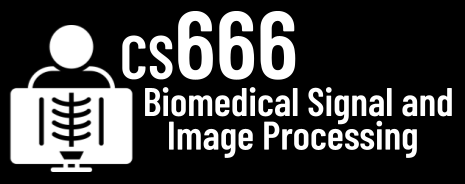

# Assignment 1

In [70]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Task 1** (5 pts): Install the BioSPPY library with the following code.

In [71]:
!pip install biosppy

**Task 2** (10 pts): Download a sample ecg dataset from https://cs666.org/data/ecg.txt and upload it to this colab. The following code loads the dataset. Note: this might fail with an import error, but should be an easy fix :)

In [72]:
!pip install peakutils

In [73]:
!wget -O ecg.txt https://cs666.org/data/ecg.txt


--2026-02-17 02:51:29--  https://cs666.org/data/ecg.txt
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105085 (103K) [text/plain]
Saving to: ‘ecg.txt’

ecg.txt             100%[===================>] 102.62K  --.-KB/s    in 0.02s   

2026-02-17 02:51:29 (6.06 MB/s) - ‘ecg.txt’ saved [105085/105085]



In [74]:
from biosppy import storage
signal, metadata = storage.load_txt('ecg.txt')

**Task 3** (10 pts): Figure out the sampling rate for this data and how many seconds it lasts.

In [75]:
SAMPLING_RATE = metadata.get('sampling_rate', metadata.get('sampling_rate_hz', 1000.0))
SECONDS = len(signal) / SAMPLING_RATE

In [76]:
SAMPLING_RATE, SECONDS

(1000.0, 15.0)

**Task 4** (15 pts): Process the signal with BioSPPY using the `ecg.ecg` method.

In [77]:
from biosppy.signals import ecg

In [78]:
import numpy as np
n = int(3 * SAMPLING_RATE)
t = np.arange(n) / SAMPLING_RATE

In [79]:
out = ecg.ecg(signal=signal, sampling_rate=SAMPLING_RATE, show = False)
out.keys()

['ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate']

In [80]:
filtered = out['filtered']
rpeaks = out['rpeaks']

**Task 5** (10 pts): Plot the first 3 seconds of the unfiltered signal and then the filtered signal. Can you spot the P, Q, R, S, T waves?

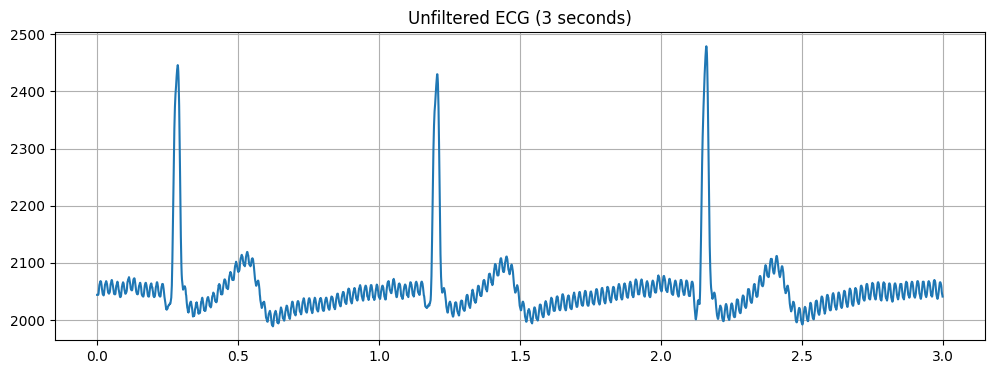

In [81]:
n = int(3 * SAMPLING_RATE)
t = np.arange(n) / SAMPLING_RATE

plt.figure(figsize=(12,4))
plt.plot(t, signal[:n])
plt.title("Unfiltered ECG (3 seconds)")
plt.grid(True)
plt.show()

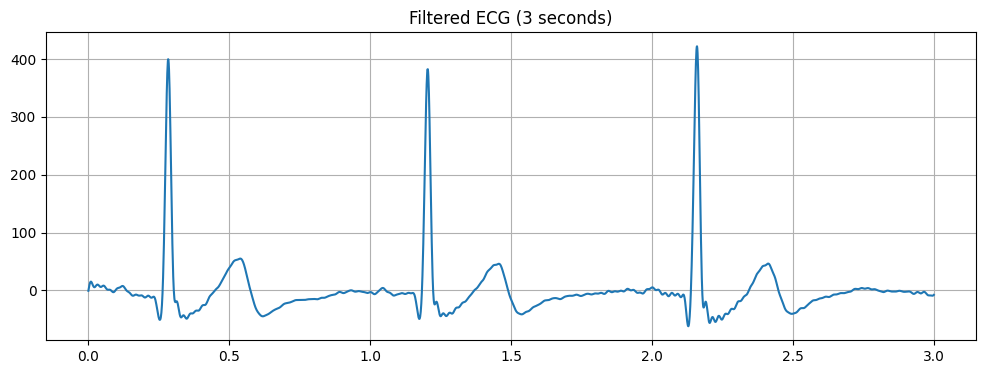

In [82]:
filtered = out['filtered']

plt.figure(figsize=(12,4))
plt.plot(t, filtered[:n])
plt.title("Filtered ECG (3 seconds)")
plt.grid(True)
plt.show()

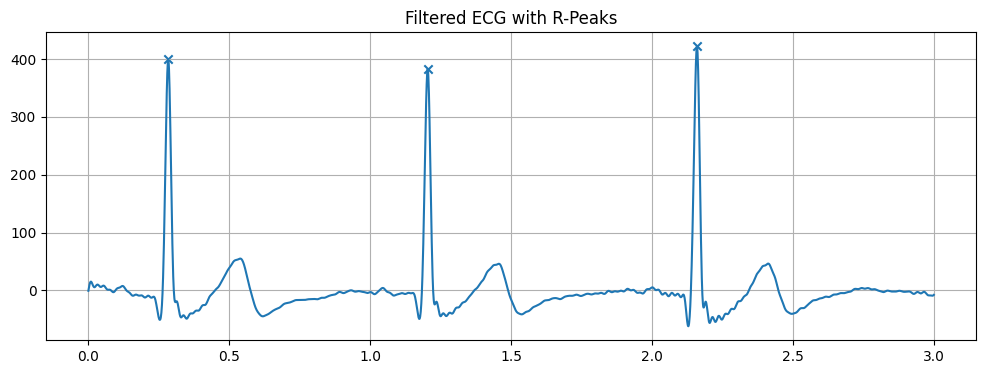

In [83]:
rpeaks = out['rpeaks']
rpeaks_3s = rpeaks[rpeaks <n]

plt.figure(figsize=(12,4))
plt.plot(t, filtered[:n])
plt.scatter(rpeaks_3s / SAMPLING_RATE, filtered[rpeaks_3s], marker = 'x')
plt.title("Filtered ECG with R-Peaks")
plt.grid(True)
plt.show()



#R wave is the tallest and marked with 'x'
#Q wave is little dip before the R wave
#S wave is little dip after the R wave
#T wave is bump after QRS
#P wave is bump before QRS

**Task 6** (15 pts): Please plot the whole filtered signal and mark the r-peaks with vertical lines based on the ecg.ecg output. You can use `plt.axvline(x = 100, color = 'r', ls=':')` to create a red, dashed vertical line at position 100. Please label the x-axis as 'time [s]'.

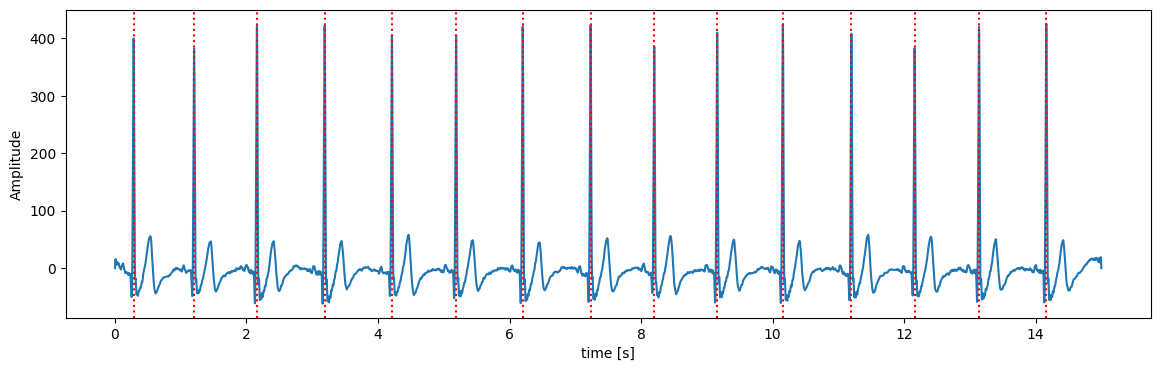

In [84]:
t_all = np.arange(len(filtered)) / SAMPLING_RATE

plt.figure(figsize=(14,4))
plt.plot(t_all, filtered)

for rp in rpeaks:
  plt.axvline(x=rp / SAMPLING_RATE, color='r', ls = ':')

plt.xlabel("time [s]")
plt.ylabel("Amplitude")
plt.show()

**Task 7** (5 pts): Let's install the NeuroKit2 library.

In [85]:
!pip install neurokit2
import neurokit2 as nk

**Task 8** (20 pts): Detect P Q S T Peaks using Neurokit.

In [86]:
ecg_cleaned = nk.ecg_clean(signal, sampling_rate=SAMPLING_RATE, method = "neurokit")

rpeaks_nk = {"ECG_R_Peaks": out["rpeaks"]}


signals_d, waves = nk.ecg_delineate(
    ecg_cleaned,
    rpeaks=rpeaks_nk,
    sampling_rate=SAMPLING_RATE,
    method="dwt"
)

waves.keys()

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

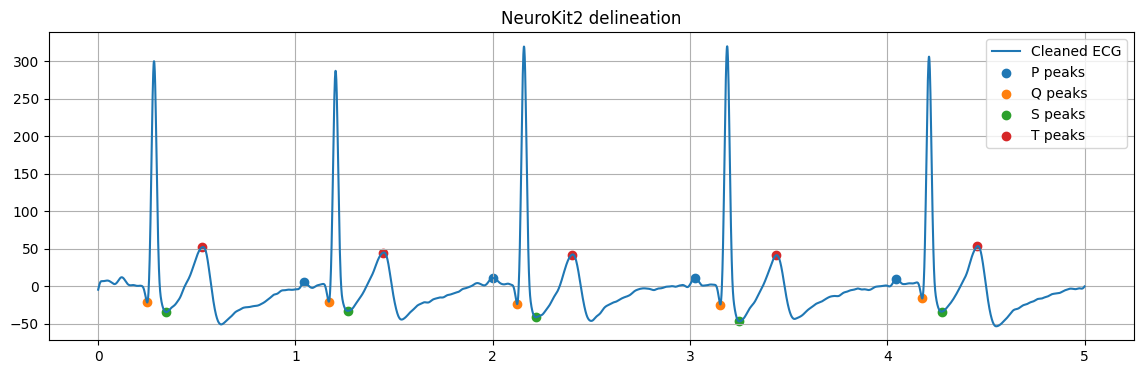

In [87]:
sec_to_plot = 5
nplot = int(sec_to_plot * SAMPLING_RATE)
t = np.arange(nplot) / SAMPLING_RATE

plt.figure(figsize=(14,4))
plt.plot(t, ecg_cleaned[:nplot], label="Cleaned ECG")

def plot_points(idxs, label):
    idxs = np.array([i for i in idxs if (i is not None and i < nplot)])
    if len(idxs) > 0:
        plt.scatter(idxs / SAMPLING_RATE, ecg_cleaned[idxs], label=label)

plot_points(waves.get("ECG_P_Peaks", []), "P peaks")
plot_points(waves.get("ECG_Q_Peaks", []), "Q peaks")
plot_points(waves.get("ECG_R_Peaks", []), "R peaks")
plot_points(waves.get("ECG_S_Peaks", []), "S peaks")
plot_points(waves.get("ECG_T_Peaks", []), "T peaks")

plt.title("NeuroKit2 delineation")
plt.legend()
plt.grid(True)
plt.show()


In [88]:
# TODO Does the detection work well?
# Yes the detection works very well, Q and S align with QRS dips, T matches hump

**Task 9** (10 pts): Use the sleepecg library to find the R Peaks.

In [89]:
!pip install sleepecg

In [90]:
import sleepecg

In [91]:
rpeaks_sleep = sleepecg.detect_heartbeats(signal, fs = SAMPLING_RATE)

In [92]:
print("BioSPPy rpeaks:", len(out["rpeaks"]))
print("sleepECG rpeaks:", len(rpeaks_sleep))

BioSPPy rpeaks: 15
sleepECG rpeaks: 15


In [93]:
import numpy as np
r1 = np.asarray(out["rpeaks"], dtype=float).reshape(-1)
r2 = np.asarray(rpeaks_sleep, dtype=float).reshape(-1)

In [94]:
import builtins
k = builtins.min(r1.size, r2.size)

In [95]:
diff2 = (r1[:k] - r2[:k])**2

In [96]:
mse = np.mean(diff2)

In [97]:
print("BioSPPy peaks:", r1.size)
print("sleepECG peaks:", r2.size)
print("MSE (samples^2):", mse)
print("MSE (seconds^2):", mse / (SAMPLING_RATE**2))

BioSPPy peaks: 15
sleepECG peaks: 15
MSE (samples^2): 0.2
MSE (seconds^2): 2.0000000000000002e-07


In [98]:
# BioSSPy sleepECG detect same 15 R peaks and very small MSE which shows their locations are identitical

**Bonus Task** (33 pts): Detect P Q S T Peaks for the full signal before and after filtering.

In [99]:
rpeaks_dict = {"ECG_R_Peaks": out["rpeaks"]}

ecg_clean_raw = nk.ecg_clean(signal, sampling_rate=SAMPLING_RATE)

signals_raw, waves_raw = nk.ecg_delineate(
    ecg_clean_raw,
    rpeaks=rpeaks_dict,
    sampling_rate=SAMPLING_RATE,
    method="dwt"
)

In [100]:
ecg_bp = nk.signal_filter(
    signal,
    sampling_rate=SAMPLING_RATE,
    lowcut=0.5,
    highcut=40,
    method="butterworth",
    order=4
)

ecg_clean_bp = nk.ecg_clean(ecg_bp, sampling_rate=SAMPLING_RATE)

signals_bp, waves_bp = nk.ecg_delineate(
    ecg_clean_bp,
    rpeaks=rpeaks_dict,
    sampling_rate=SAMPLING_RATE,
    method="dwt"
)

In [101]:
ecg_bio_filtered = out["filtered"]

ecg_clean_bio = nk.ecg_clean(ecg_bio_filtered, sampling_rate=SAMPLING_RATE)

signals_bio, waves_bio = nk.ecg_delineate(
    ecg_clean_bio,
    rpeaks=rpeaks_dict,
    sampling_rate=SAMPLING_RATE,
    method="dwt"
)


In [102]:
def count_waves(waves):
    return {
        "P": len([x for x in waves.get("ECG_P_Peaks", []) if x is not None]),
        "Q": len([x for x in waves.get("ECG_Q_Peaks", []) if x is not None]),
        "R": len([x for x in waves.get("ECG_R_Peaks", []) if x is not None]),
        "S": len([x for x in waves.get("ECG_S_Peaks", []) if x is not None]),
        "T": len([x for x in waves.get("ECG_T_Peaks", []) if x is not None]),
    }

print("Raw:", count_waves(waves_raw))
print("Bandpass:", count_waves(waves_bp))
print("BioSPPy filtered:", count_waves(waves_bio))
print("R peaks count (from biosppy):", len(out["rpeaks"]))


Raw: {'P': 15, 'Q': 15, 'R': 0, 'S': 15, 'T': 15}
Bandpass: {'P': 15, 'Q': 15, 'R': 0, 'S': 15, 'T': 15}
BioSPPy filtered: {'P': 15, 'Q': 15, 'R': 0, 'S': 15, 'T': 15}
R peaks count (from biosppy): 15


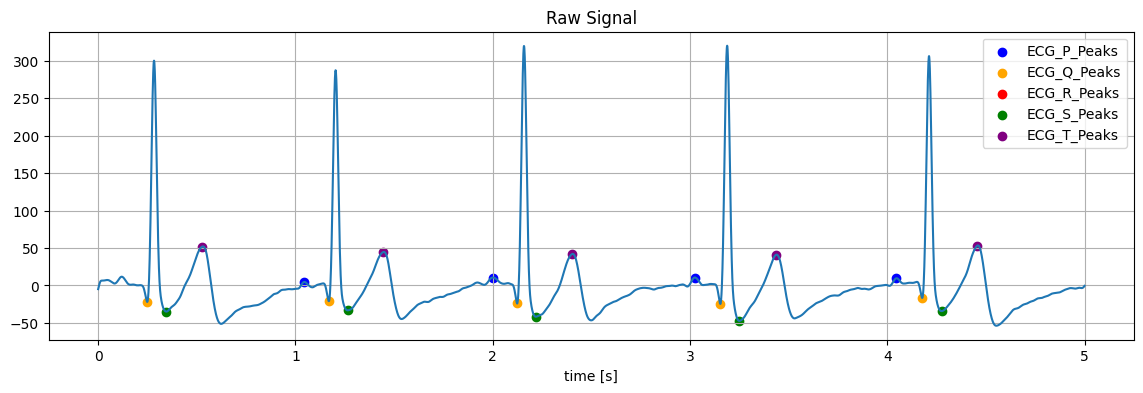

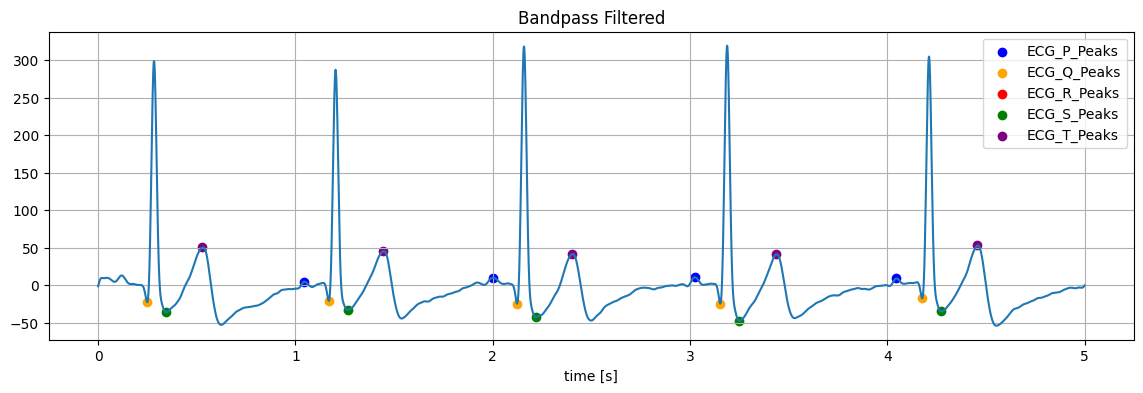

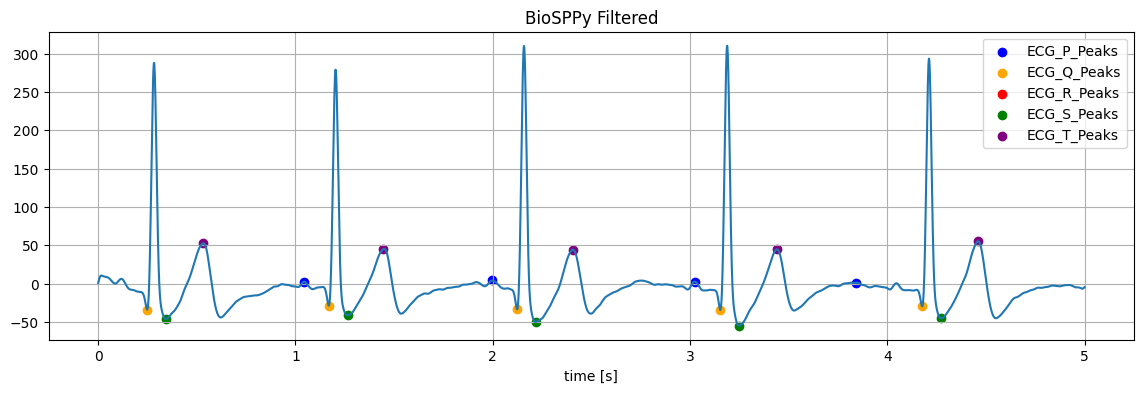

In [103]:
def plot_short(ecg_sig, waves, title):
    n = int(5 * SAMPLING_RATE)
    t = np.arange(n) / SAMPLING_RATE

    plt.figure(figsize=(14,4))
    plt.plot(t, ecg_sig[:n])

    for key, color in zip(
        ["ECG_P_Peaks","ECG_Q_Peaks","ECG_R_Peaks","ECG_S_Peaks","ECG_T_Peaks"],
        ["blue","orange","red","green","purple"]
    ):
        idx = [i for i in waves.get(key, []) if i is not None and i < n]
        plt.scatter(np.array(idx)/SAMPLING_RATE, ecg_sig[idx], color=color, label=key)

    plt.xlabel("time [s]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_short(ecg_clean_raw, waves_raw, "Raw Signal")
plot_short(ecg_clean_bp, waves_bp, "Bandpass Filtered")
plot_short(ecg_clean_bio, waves_bio, "BioSPPy Filtered")


In [104]:
# TODO Which one works the best?
# Raw had slight nosises
# Bandpass is smooth and consistent
# BioSPPY is also smooth
# BioSSPY is best because it is more clean, smooth and PQST were consistent

In [105]:
#
# Great job!!
#
#  , ; ,   .-'"""'-.   , ; ,
#  \\|/  .'         '.  \|//
#   \-;-/   ()   ()   \-;-/
#   // ;               ; \\
#  //__; :.         .; ;__\\
# `-----\'.'-.....-'.'/-----'
#        '.'.-.-,_.'.'
#jgs       '(  (..-'
#            '-'
#